# Re-analysis of LF2012

Geoffrey Brookshire

This notebook shows several analyses of data provided by Ayelet Landau for Landau and Fries (2012). These data-sets cannot be used for re-analysis, because none of them exactly match the time-series plotted in Fig. 2 of LF2012.

In [1]:
import os
os.chdir('..')

In [2]:
# Import libraries and set up analyses
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

plt.ion()

data_dir = 'external_data/'
data_dir += 'lf2012/'
plot_dir = 'plots/'

np.random.seed(0)

In [3]:
fs = 60  # From the paper
k_perm = 1000
rt_thresh = 1.0  # Responses slower than this are counted as a miss

colors = {0: 'r', 1: 'b'}  # Plot valid/invalid as in LF2012
validity_labels = {0: 'Same',
                   1: 'Opposite'}
targ_side_labels = {1: 'Left',
                    2: 'Right'}

# Analyze individual trial data

Starting with the raw hits and misses for each trial, try to reconstruct the time-series in the plotted figures.

In [4]:
# Load the data
raw_data_dir = data_dir + 'raw_allSubjects_forBrookshire/'
fnames = os.listdir(raw_data_dir)
fields = ['trgtSide', 'validity',
          'thisResponse', 'RT',
          'ONtrgtISI', 'ONtrgtISInan',
          'trgtUP', 'probeUP']
d_all = []

for fn in fnames:
    d_i = scipy.io.loadmat(raw_data_dir + fn)
    
    def get_field(field):
        """ Helper function to extract a column of data
        """
        return d_i['history'][field][0][0].flatten()
    
    # Put the data together into a data frame
    d_dict = {field: get_field(field) for field in fields}
    d_df = pd.DataFrame.from_dict(d_dict)
    d_df['subject'] = fn[4:-4]  # Get the subject ID
    d_all.append(d_df)
    
d_all = pd.concat(d_all, ignore_index=True)
del d_i, d_dict, d_df

# Exclude trials with no target
d_all = d_all[~np.isnan(d_all['ONtrgtISInan'])]

# Get whether each trial is a hit or a miss
hit = d_all['thisResponse'] == 1  # Convert to bool
d_all['RT'][np.isnan(d_all['RT'])] = np.inf # NaN <-- infinity
within_time_limit = d_all['RT'] < rt_thresh
d_all['resp'] = hit & within_time_limit

# Compute the ISI based on the time of stim appearance
d_all['t_alt'] = d_all['trgtUP'] - d_all['probeUP']

# Data checks
n_subjects = 16  # Make sure we have the N in the paper
assert len(np.unique(d_all['subject'])) == n_subjects
print('Data sampling rate:',
      f'{1 / np.mean(np.diff(np.unique(d_all["ONtrgtISI"])))}')

Data sampling rate: 58.85714285714286


Here I try two ways of analyzing these data, both based on suggestions from AL. First, I use a sliding window to get the hit-rate over time. This approach uses the time-stamps for the actual appearance of the reset stimulus and target stimulus.

Second, I use the time-stamps of the intended delay between reset and target, and average the hit rate at each delay.

## Sliding window approach

Analyze the data with a sliding window. The ISI time is computed as `trgtUP - probeUP`.

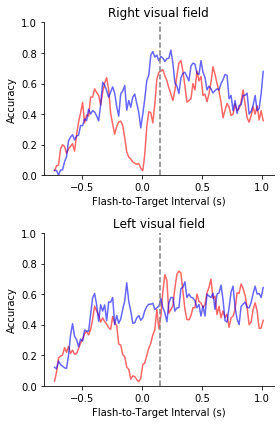

In [5]:
# Sliding window

# Binning details given by AL
bin_starts = np.arange(-0.75, 1.0, 1/60)
bin_ends = bin_starts + 0.050
bin_centers = np.mean([bin_starts, bin_ends], axis=0)

plt.figure(figsize=(4, 6))
for i_plot, targ_side in enumerate((2, 1)):
    plt.subplot(2, 1, i_plot + 1)
    for val in (0, 1):
        cond_sel = (
            (d_all['trgtSide'] == targ_side)
            & (d_all['validity'] == val)
        )
        d_cond = d_all[cond_sel]
        hit_rate = []
        for b_start, b_end in zip(bin_starts, bin_ends):
            t_sel = (
                (d_cond['t_alt'] >= b_start)
                & (d_cond['t_alt'] < b_end)
            )
            x = np.mean(d_cond['resp'][t_sel])
            hit_rate.append(x)
        plt.plot(bin_centers, hit_rate,
                 color=colors[val], alpha=0.6)
    plt.title(f'{targ_side_labels[targ_side]} visual field')
    plt.axvline(x=0.15, color='grey', linestyle='--')
    plt.ylim(0, 1)
    plt.xlabel('Flash-to-Target Interval (s)')
    plt.ylabel('Accuracy')
    # Remove the top and right axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

This time-series is similar to the time-series from the paper, but it also shows a number of differences. For example, the original unsmoothed time-series of "same" trials in the right visual field has accuracy of 0 at one sample around -0.8 s. The time-series I've plotted here does not touch 0.

Furthermore, this analysis shows very low performance before the target. It turns out there are NaN's in this timing measure, especially at the earlier portion of the time-series. These happen because of NaN's in `probeUP`.

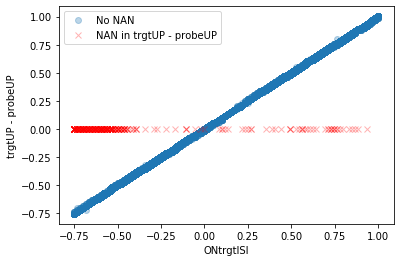

In [6]:
plt.plot(d_all['ONtrgtISI'], d_all['t_alt'],
         'o', alpha=0.3, label='No NAN')
nan_inx = np.isnan(d_all['t_alt'])
plt.plot(d_all['ONtrgtISI'][nan_inx],
         np.zeros(nan_inx.sum()),
         'rx', alpha=0.3, label='NAN in trgtUP - probeUP')
plt.xlabel('ONtrgtISI')
plt.ylabel('trgtUP - probeUP')
plt.legend()

In [7]:
# Print a few lines of this data frame
d_all[nan_inx][['probeUP', 'trgtUP']].head()

,probeUP,trgtUP
7,NaN,1.203899
44,NaN,1.303834
57,NaN,1.487694
78,NaN,1.520499
88,NaN,1.270766


Because of these NaNs, we can't reconstruct the correct time-series using this sliding window approach.

## Discrete time-steps

Average over the reset-target delays given in `ONtrgtISI`.

In [8]:
# Average over each time point for each condition
d_avg = (
    d_all
    .drop(['subject', 'ONtrgtISInan'], axis=1)
    .groupby(['trgtSide', 'validity', 'ONtrgtISI'],
             as_index=False)
    .agg({'resp': np.mean})
    )

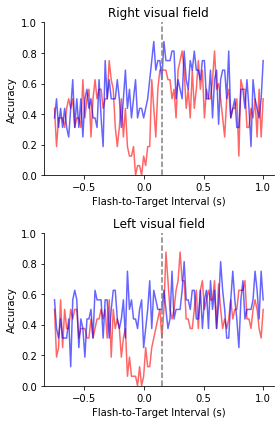

In [9]:
# Plot the time-series
plt.figure(figsize=(4, 6))
for i_plot, targ_side in enumerate((2, 1)):
    plt.subplot(2, 1, i_plot + 1)
    for val in (0, 1):
        # Extract the data for this condition
        inx = (
            (d_avg['validity'] == val)
            & (d_avg['trgtSide'] == targ_side)
        )
        d_cond = d_avg.loc[inx, :]
        plt.plot(d_cond['ONtrgtISI'],
                 d_cond['resp'],
                 color=colors[val], alpha=0.6)
    # Format the plots
    plt.title(f'{targ_side_labels[targ_side]} visual field')
    plt.axvline(x=0.15, color='grey', linestyle='--')
    plt.ylim(0, 1)
    plt.xlabel('Flash-to-Target Interval (s)')
    plt.ylabel('Accuracy')
    # Remove the top and right axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

This analysis also shows high-level similarities to the unsmoothed data in Fig. 2a, but again it is not identical. For example, the original data for the "same" condition in the right visual field has accuracy = 0 at one time-point before t=0. In contrast, the time-series plotted above shows accuracy = 0 at two separate places before t=0. As a second example, the original data show a wide separation between the "same" and "opposite" conditions immediately after t=0 (Fig. 2a), whereas these analyses show the two time-series almost touching.

# Pre-processed time-series

Analyze pre-processed time-series that were provided by Ayelet Landau.

## Detrended time-series

Analyze the time-series in `dataL` and `dataR`. These data have been aggregated within each subject and detrended.

In [10]:
# Load the data
d = {side: scipy.io.loadmat(f'{data_dir}data{side}')[f'data{side}']
     for side in 'RL'}
# Get the accuracy time-series for each subject
acc = {side: np.squeeze(np.stack(d[side]['trial'][0][0].tolist()))
       for side in 'RL'}
# Average over subjects to get an array of (validity, time-point)
acc = {side: np.mean(arr, axis=0)
       for side, arr in acc.items()}
# Get the time-vector
t = d['R']['time'][0][0][0][0].flatten()

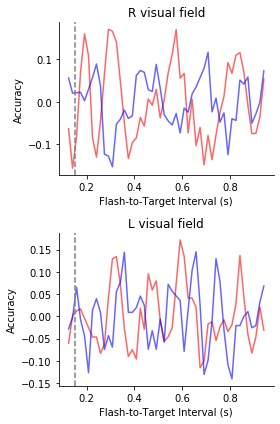

In [11]:
# Plot the time-series
plt.figure(figsize=(4, 6))
for i_plot, targ_side in enumerate('RL'):
    plt.subplot(2, 1, i_plot + 1)
    for val in (0, 1):
        # Extract the data for this condition
        plt.plot(t,
                 acc[targ_side][val],
                 color=colors[val], alpha=0.6)
    # Format the plots
    plt.title(f'{targ_side} visual field')
    plt.axvline(x=0.15, color='grey', linestyle='--')
    plt.xlabel('Flash-to-Target Interval (s)')
    plt.ylabel('Accuracy')
    # Remove the top and right axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

These time-series are similar to a detrended version of the plotted data, but not exactly the same. For example, the blue "opposite" trace in Fig. 2a has three sharp troughs between 0.7 and 1.0 s, whereas the data plotted here (top subplot) have only two troughs in that interval. As a second example, the "same" trace in Fig. 2a has a single sharp downward spike around t=0.7, whereas the data plotted here show a smoother dip. As a third example, Fig. 2a shows a sharp downward spike within the broad peak just before t=0.8, whereas the data plotted here show a smooth peak.

## Hit rate for each subject

Analyze the averaged hit rate for each subject, given in `hitR` and `hitR`.

In [12]:
# Load the data
conditions = ['valid', 'invalid']
d = {side: scipy.io.loadmat(f'{data_dir}hit{side}')
     for side in 'RL'}
acc = {side: {cond: np.mean(d[side][f'HIT{cond}'], axis=0)
              for cond in conditions}
       for side in 'RL'}
t = d['R']['winCen'].flatten()

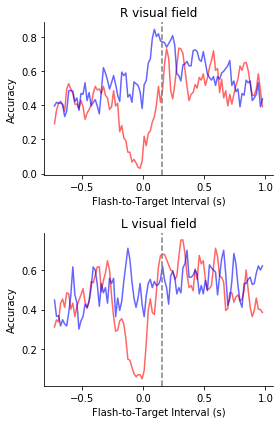

In [13]:
# Plot the time-series
plt.figure(figsize=(4, 6))
for i_plot, targ_side in enumerate('RL'):
    plt.subplot(2, 1, i_plot + 1)
    for i_val, val in enumerate(conditions):
        # Extract the data for this condition
        plt.plot(t,
                 acc[targ_side][val],
                 color=colors[i_val], alpha=0.6)
    # Format the plots
    plt.title(f'{targ_side} visual field')
    plt.axvline(x=0.15, color='grey', linestyle='--')
    plt.xlabel('Flash-to-Target Interval (s)')
    plt.ylabel('Accuracy')
    # Remove the top and right axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

These time-series appear to be a smoothed version of the data plotted in Fig. 2 of LF2012. It's an intermediate amount of smoothing between the raw data and the smoothed data in the plot. Because the smoothing changes the estimate of the AR(1) parameter, these data cannot be used for the AR surrogate or robust est. analyses.